![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


filename_features = "C:/Users/ander/EBAC/PCA/Dados/UCI HAR Dataset/features.txt"
filename_labels = "C:/Users/ander/EBAC/PCA/Dados/UCI HAR Dataset/activity_labels.txt"
filename_subtrain = "C:/Users/ander/EBAC/PCA/Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "C:/Users/ander/EBAC/PCA/Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "C:/Users/ander/EBAC/PCA/Dados/UCI HAR Dataset/train/y_train.txt"
filename_subtest = "C:/Users/ander/EBAC/PCA/Dados/UCI HAR Dataset/test/subject_test.txt"
filename_xtest = "C:/Users/ander/EBAC/PCA/Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "C:/Users/ander/EBAC/PCA/Dados/UCI HAR Dataset/test/y_test.txt"

# Carregar features (nomes das colunas)
features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep=r"\s+").squeeze("columns")

# Resolver duplicatas nos nomes das colunas
if features.duplicated().any():
    features = features + "_" + features.groupby(features).cumcount().astype(str).replace("0", "")

# Carregar os dados
labels = pd.read_csv(filename_labels, sep=r"\s+", header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id']).squeeze("columns")
X_train = pd.read_csv(filename_xtrain, sep=r"\s+", header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id']).squeeze("columns")
X_test = pd.read_csv(filename_xtest, sep=r"\s+", header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [3]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)

X_train_pad.head()

CPU times: total: 250 ms
Wall time: 240 ms


,tBodyAcc-mean()-X_,tBodyAcc-mean()-Y_,tBodyAcc-mean()-Z_,tBodyAcc-std()-X_,tBodyAcc-std()-Y_,tBodyAcc-std()-Z_,tBodyAcc-mad()-X_,tBodyAcc-mad()-Y_,tBodyAcc-mad()-Z_,tBodyAcc-max()-X_,...,fBodyBodyGyroJerkMag-meanFreq()_,fBodyBodyGyroJerkMag-skewness()_,fBodyBodyGyroJerkMag-kurtosis()_,"angle(tBodyAccMean,gravity)_","angle(tBodyAccJerkMean),gravityMean)_","angle(tBodyGyroMean,gravityMean)_","angle(tBodyGyroJerkMean,gravityMean)_","angle(X,gravityMean)_","angle(Y,gravityMean)_","angle(Z,gravityMean)_"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


In [23]:
X_test_pad  = pd.DataFrame(X_test).apply(padroniza, axis=0)
X_test_pad.head()

,tBodyAcc-mean()-X_,tBodyAcc-mean()-Y_,tBodyAcc-mean()-Z_,tBodyAcc-std()-X_,tBodyAcc-std()-Y_,tBodyAcc-std()-Z_,tBodyAcc-mad()-X_,tBodyAcc-mad()-Y_,tBodyAcc-mad()-Z_,tBodyAcc-max()-X_,...,fBodyBodyGyroJerkMag-meanFreq()_,fBodyBodyGyroJerkMag-skewness()_,fBodyBodyGyroJerkMag-kurtosis()_,"angle(tBodyAccMean,gravity)_","angle(tBodyAccJerkMean),gravityMean)_","angle(tBodyGyroMean,gravityMean)_","angle(tBodyGyroJerkMean,gravityMean)_","angle(X,gravityMean)_","angle(Y,gravityMean)_","angle(Z,gravityMean)_"
0,-0.277661,-0.210595,2.192704,-0.787134,-0.833071,-0.093428,-0.807954,-0.838871,-0.104160,-0.824606,...,-0.253620,-0.166362,-0.344707,0.003565,0.357512,-1.363669,0.575389,-0.404722,0.622618,-0.038342
1,0.198626,0.182560,-0.250221,-0.876836,-0.928903,-0.857905,-0.896993,-0.928791,-0.863122,-0.824606,...,-2.300359,0.490938,0.012254,-0.264048,0.030782,-0.747105,1.870875,-0.361677,0.636623,-0.145684
2,0.024583,-0.318001,-0.228446,-0.921442,-0.933896,-0.906953,-0.916735,-0.933654,-0.912484,-0.910827,...,-0.291514,0.274775,-0.134966,-0.119651,0.445996,0.037913,0.323883,-0.370869,0.632738,-0.126834
3,-0.061047,-0.572940,-0.213673,-0.923681,-0.940657,-0.918926,-0.918996,-0.941439,-0.927619,-0.909586,...,-0.058615,-0.210642,-0.441639,-0.066432,0.338455,0.472614,0.625768,-0.363372,0.645167,-0.117565
4,0.013820,-0.387815,-0.494555,-0.921523,-0.928878,-0.949818,-0.915977,-0.923689,-0.951235,-0.909586,...,-1.090596,-0.810389,-0.796804,-0.022272,-0.098513,1.097162,-0.201965,-0.350197,0.665544,-0.104100


**PCA Sem Padronização**

In [5]:
%%time

pca = PCA()
# Cria uma instância do objeto PCA, que será usado para realizar a análise de componentes principais

princomp = pca.fit(X_train)
# Ajusta o PCA aos dados de treinamento para extrair as componentes principais

componentes = princomp.transform(X_train)
# Transforma os dados de treinamento nas componentes principais

n_componentes = X_train.shape[1]
# Obtém o número de colunas dos dados de treinamento

nomes_pca = ['CP' + str(x+1) for x in list(range(n_componentes))]
# Cria uma lista de nomes para as componentes principais (CP1, CP2, CP3, ...)

pd.DataFrame(data=componentes, columns=nomes_pca).head()
# Visualiza o DataFrame com os dados transformados (componentes) e atribui os nomes_pca como nomes de colunas

CPU times: total: 641 ms
Wall time: 182 ms


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-5.520280,0.290278,1.529929,-1.333242,1.425089,0.194708,0.577454,0.691490,-1.222865,-0.363414,...,2.174731e-09,-1.508908e-09,-3.217642e-10,-2.173255e-09,-1.904670e-09,2.080347e-09,5.231922e-10,1.000226e-09,-9.087870e-10,1.343908e-09
1,-5.535350,0.082530,1.924804,-0.671273,0.671260,-0.735144,-0.616908,-0.771714,-0.615496,-0.895525,...,-2.716034e-09,-7.199049e-10,-1.940100e-09,2.469111e-09,-7.130285e-10,2.211723e-09,1.486825e-09,1.528531e-09,7.001927e-09,-2.677187e-09
2,-5.474988,-0.287387,2.144642,-0.531806,0.207824,0.037772,0.057628,0.093917,-0.063147,-0.216898,...,-3.438458e-10,4.520718e-09,-1.549884e-09,2.284201e-09,-5.195641e-10,-3.404054e-09,2.779046e-09,-1.930746e-09,-1.463722e-09,4.886528e-10
3,-5.677232,-0.897031,2.018220,-0.157125,0.759085,-1.079547,-0.267805,-0.731391,0.281296,0.466269,...,-8.040634e-10,1.151424e-09,5.661627e-09,-6.761588e-10,-1.479123e-09,1.438215e-09,4.653628e-09,-3.794019e-09,6.865936e-10,-3.111922e-09
4,-5.748749,-1.162952,2.139533,-0.207823,0.473090,-0.463035,-0.152227,-0.107509,0.289819,0.539206,...,2.551444e-09,-1.531946e-09,1.832350e-09,-2.715760e-09,7.013066e-09,1.209449e-09,-1.568715e-09,-1.230240e-09,-1.420044e-09,-4.655744e-09


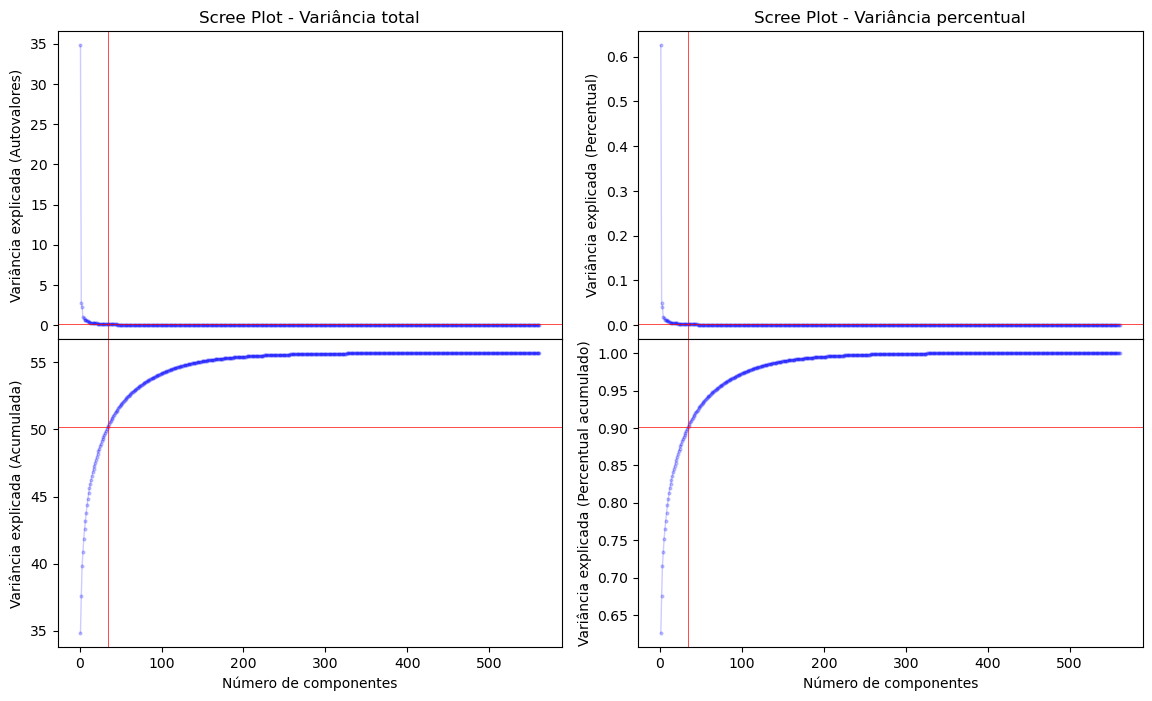

Para explicar 90% da variância sem a padronização das variáveis, são necessárias 34 componentes.


In [8]:
# Critério: Variância explicada

# Cria uma figura com 2 linhas e 2 colunas de subplots e ajusta o espaço entre eles
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério
varexplicada = .90  # Define a variância explicada desejada
ncomp_criterio = (princomp.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1
# Calcula o número de componentes necessário para atingir a variância explicada desejada

# Gráfico da variância nominal por quantidade de componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0, 0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0 ,0].set_title('Scree Plot - Variância total')
ax[0, 0].set_xlabel('Número de componentes')
ax[0, 0].set_ylabel('Variância explicada (Autovalores)')

# Gráfico da variância nominal acumulada por quantidade de componentes
ax[1, 0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 0].set_xlabel('Número de componentes')
ax[1, 0].set_ylabel('Variância explicada (Acumulada)')

# Gráfico da variância percentual por quantidade de componentes
ax[0, 1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0, 1].set_title('Scree Plot - Variância percentual')
ax[0, 1].set_xlabel('Número de componentes')
ax[0, 1].set_ylabel('Variância explicada (Percentual)')

# Gráfico da variância percentual acumulada por quantidade de componentes
ax[1, 1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 1].set_xlabel('Número de componentes')
ax[1, 1].set_ylabel('Variância explicada (Percentual acumulado)')

# Linhas verticais de referência
ax[0, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[0, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)

# Linhas horizontais de referência
ax[0, 0].axhline(y=princomp.explained_variance_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 0].axhline(y=princomp.explained_variance_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[0, 1].axhline(y=princomp.explained_variance_ratio_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 1].axhline(y=princomp.explained_variance_ratio_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)

plt.show()

print(f'Para explicar 90% da variância sem a padronização das variáveis, são necessárias {ncomp_criterio} componentes.')

In [9]:
variancia               = princomp.explained_variance_[ncomp_criterio - 1]
variancia_acumulada     = princomp.explained_variance_.cumsum()[ncomp_criterio - 1]
pct_variancia           = princomp.explained_variance_ratio_[ncomp_criterio - 1]
pct_variancia_acumulada = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio - 1]

print(f'Número de componentes:...................... {ncomp_criterio}')

print(f'Variância da última CP:..................... {variancia:.2f}')
print(f'Variância acumulada da última CP:........... {variancia_acumulada:.2f}')
print(f'Variância percentual da última CP:.......... {100*pct_variancia:.2f}%')
print(f'Variância percentual acumulada da última CP: {100*pct_variancia_acumulada:.2f}%')

Número de componentes:...................... 34
Variância da última CP:..................... 0.13
Variância acumulada da última CP:........... 50.15
Variância percentual da última CP:.......... 0.24%
Variância percentual acumulada da última CP: 90.09%


In [10]:
pca_raw = pd.DataFrame(data={'variancia': princomp.explained_variance_[:ncomp_criterio], 
                             'variancia_acumulada': princomp.explained_variance_.cumsum()[:ncomp_criterio], 
                             'pct_variancia': princomp.explained_variance_ratio_[:ncomp_criterio], 
                             'pct_variancia_acumulada': princomp.explained_variance_ratio_.cumsum()[:ncomp_criterio]}, 
                       index=list(range(1, ncomp_criterio+1)))
pca_raw.index.name = 'CP'
pca_raw.head()

,variancia,variancia_acumulada,pct_variancia,pct_variancia_acumulada
CP,,,,
1,34.823630,34.823630,0.625544,0.625544
2,2.735046,37.558677,0.049130,0.674675
3,2.294393,39.853070,0.041215,0.715889
4,1.043775,40.896845,0.018750,0.734639
5,0.943517,41.840362,0.016949,0.751587


**PCA Com Padronização**

In [12]:
%%time

pca_pad = PCA()
# Cria uma instância do objeto PCA, que será usado para realizar a análise de componentes principais

princomp_pad = pca_pad.fit(X_train_pad)
# Ajusta o PCA aos dados de treinamento para extrair as componentes principais

componentes_pad = princomp_pad.transform(X_train_pad)
# Transforma os dados de treinamento nas componentes principais

n_componentes_pad = X_train_pad.shape[1]
# Obtém o número de colunas dos dados de treinamento

nomes_pca_pad = ['CP' + str(x+1) for x in list(range(n_componentes_pad))]
# Cria uma lista de nomes para as componentes principais (CP1, CP2, CP3, ...)

pd.DataFrame(data=componentes_pad, columns=nomes_pca_pad).head()
# Visualiza o DataFrame com os dados transformados (componentes) e atribui os nomes_pca como nomes de colunas

CPU times: total: 672 ms
Wall time: 179 ms


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-16.137446,2.151878,-3.144566,0.272446,-6.798476,-4.249105,2.936959,-4.905079,0.775462,3.627490,...,-2.625030e-09,1.024365e-08,2.758772e-09,-2.877883e-08,-1.775638e-08,8.406333e-10,5.032942e-09,2.011799e-08,2.407589e-10,7.306757e-09
1,-15.295154,1.387049,0.682175,-2.813486,-4.265880,-2.055523,0.011204,-1.845860,-0.492513,0.180162,...,-1.746414e-09,1.285742e-08,-2.389512e-08,-1.328019e-09,-5.616823e-09,1.383315e-08,-1.691527e-08,1.996825e-08,-2.315821e-08,2.320429e-08
2,-15.135989,2.473183,1.756521,-3.717722,-4.181273,-1.357425,0.072942,-1.388094,-0.539717,0.671666,...,-1.364761e-09,2.586198e-08,1.399891e-08,-6.858262e-10,-1.933901e-08,-1.498089e-08,1.683456e-08,2.393291e-08,-1.901798e-08,-2.472953e-08
3,-15.349840,3.915414,1.790201,-2.567347,-3.205621,-0.942880,0.530700,-1.832060,-1.071444,1.496887,...,2.665095e-09,-5.267068e-08,2.308127e-08,3.905989e-09,1.499114e-08,-7.972152e-09,2.735810e-08,-3.112903e-08,-1.495148e-08,-6.170104e-09
4,-15.543756,4.598424,2.188433,-2.897381,-3.079941,-1.061386,-1.048520,-0.816877,-0.600022,-1.118799,...,2.164853e-09,9.511504e-09,-1.795309e-08,2.673799e-08,-3.065509e-08,-1.193472e-09,1.272575e-08,1.183752e-08,-2.207812e-08,-7.559161e-09


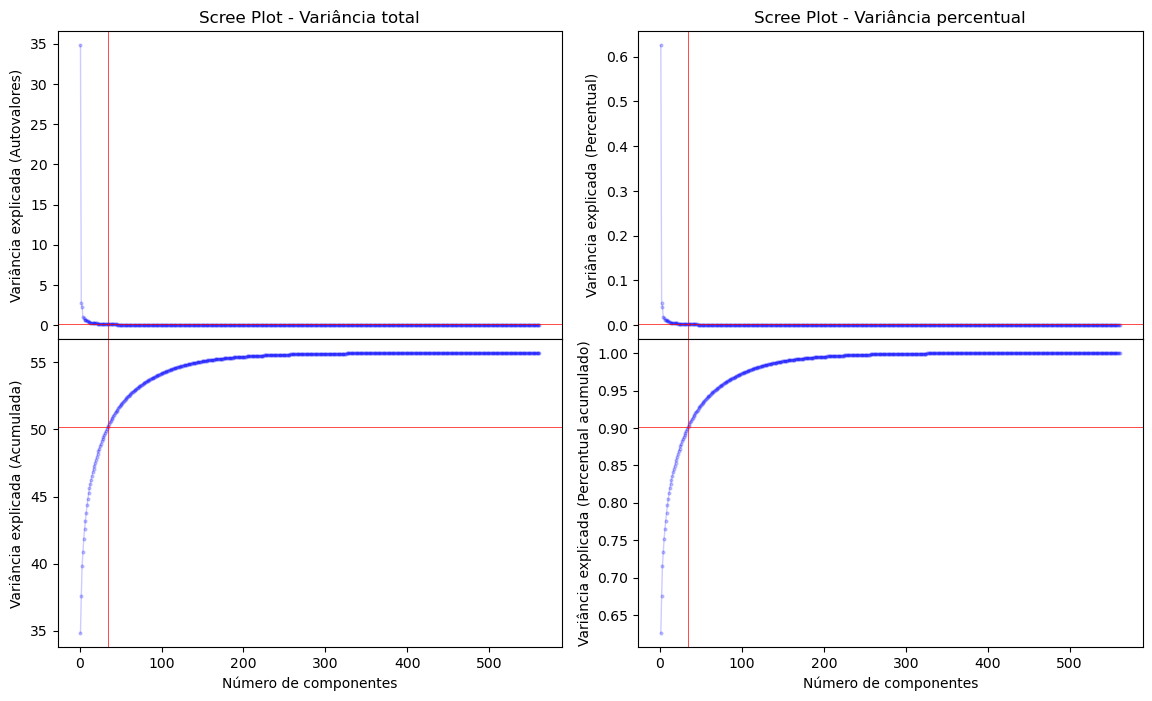

Para explicar 90% da variância sem a padronização das variáveis, são necessárias 34 componentes.


In [16]:
# Critério: Variância explicada

# Cria uma figura com 2 linhas e 2 colunas de subplots e ajusta o espaço entre eles
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério
varexplicada = .90  # Define a variância explicada desejada
ncomp_criterio = (princomp.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1
# Calcula o número de componentes necessário para atingir a variância explicada desejada

# Gráfico da variância nominal por quantidade de componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0, 0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0 ,0].set_title('Scree Plot - Variância total')
ax[0, 0].set_xlabel('Número de componentes')
ax[0, 0].set_ylabel('Variância explicada (Autovalores)')

# Gráfico da variância nominal acumulada por quantidade de componentes
ax[1, 0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 0].set_xlabel('Número de componentes')
ax[1, 0].set_ylabel('Variância explicada (Acumulada)')

# Gráfico da variância percentual por quantidade de componentes
ax[0, 1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0, 1].set_title('Scree Plot - Variância percentual')
ax[0, 1].set_xlabel('Número de componentes')
ax[0, 1].set_ylabel('Variância explicada (Percentual)')

# Gráfico da variância percentual acumulada por quantidade de componentes
ax[1, 1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 1].set_xlabel('Número de componentes')
ax[1, 1].set_ylabel('Variância explicada (Percentual acumulado)')

# Linhas verticais de referência
ax[0, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[0, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)

# Linhas horizontais de referência
ax[0, 0].axhline(y=princomp.explained_variance_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 0].axhline(y=princomp.explained_variance_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[0, 1].axhline(y=princomp.explained_variance_ratio_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 1].axhline(y=princomp.explained_variance_ratio_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)

plt.show()

print(f'Para explicar 90% da variância sem a padronização das variáveis, são necessárias {ncomp_criterio} componentes.')

In [18]:
variancia               = princomp_pad.explained_variance_[ncomp_criterio_pad - 1]
variancia_acumulada     = princomp_pad.explained_variance_.cumsum()[ncomp_criterio_pad - 1]
pct_variancia           = princomp_pad.explained_variance_ratio_[ncomp_criterio_pad - 1]
pct_variancia_acumulada = princomp_pad.explained_variance_ratio_.cumsum()[ncomp_criterio_pad - 1]

print(f'Número de componentes:...................... {ncomp_criterio_pad}')

print(f'Variância da última CP:..................... {variancia:.2f}')
print(f'Variância acumulada da última CP:........... {variancia_acumulada:.2f}')
print(f'Variância percentual da última CP:.......... {100*pct_variancia:.2f}%')
print(f'Variância percentual acumulada da última CP: {100*pct_variancia_acumulada:.2f}%')

Número de componentes:...................... 63
Variância da última CP:..................... 0.99
Variância acumulada da última CP:........... 505.20
Variância percentual da última CP:.......... 0.18%
Variância percentual acumulada da última CP: 90.05%


In [19]:
pca_pad = pd.DataFrame(data={'variancia': princomp_pad.explained_variance_[:ncomp_criterio_pad], 
                             'variancia_acumulada': princomp_pad.explained_variance_.cumsum()[:ncomp_criterio_pad], 
                             'pct_variancia': princomp_pad.explained_variance_ratio_[:ncomp_criterio_pad], 
                             'pct_variancia_acumulada': princomp_pad.explained_variance_ratio_.cumsum()[:ncomp_criterio_pad]}, 
                       index=list(range(1, ncomp_criterio_pad+1)))
pca_pad.index.name = 'CP'
pca_pad.head()

,variancia,variancia_acumulada,pct_variancia,pct_variancia_acumulada
CP,,,,
1,284.882377,284.882377,0.507812,0.507812
2,36.917616,321.799993,0.065807,0.573619
3,15.744110,337.544103,0.028064,0.601683
4,14.047175,351.591278,0.025040,0.626722
5,10.593279,362.184557,0.018883,0.645605


## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

**Árvore de decisão com base em dados não padronizados**

In [21]:
%%time

# Aplica o PCA com 10 componentes aos dados de treinamento SEM padronização
prcomp = PCA(n_components=10).fit(X_train)

# Transforma os dados de treinamento e teste utilizando as componentes principais encontradas pelo PCA
pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

# Imprime a forma dos dados de treinamento e teste após a transformação
print(f'Dimensões da base de treinamento: {pc_treino.shape}')
print(f'Dimensões da base de teste: {pc_teste.shape}\n')

# Inicializa um classificador de árvore de decisão com ccp_alpha=0.001 e treina-o com os dados de treinamento transformados
clf = DecisionTreeClassifier(ccp_alpha=0.001)
clf.fit(pc_treino, y_train)

# Calcula e imprime a acurácia do classificador nos dados de treinamento e teste
print(f'Acurácia na base de treinamento: {clf.score(pc_treino, y_train)}')
print(f'Acurácia na base de teste: {clf.score(pc_teste, y_test)}\n')

Dimensões da base de treinamento: (7352, 10)
Dimensões da base de teste: (2947, 10)

Acurácia na base de treinamento: 0.8926822633297062
Acurácia na base de teste: 0.8238887003732609

CPU times: total: 1.09 s
Wall time: 289 ms


**Árvore de decisão com base em dados padronizados**

In [24]:
%%time

# Aplica o PCA com 10 componentes aos dados de treinamento COM padronização
prcomp_pad = PCA(n_components=10).fit(X_train_pad)

# Transforma os dados de treinamento e teste utilizando as componentes principais encontradas pelo PCA
pc_treino_pad = prcomp_pad.transform(X_train_pad)
pc_teste_pad  = prcomp_pad.transform(X_test_pad)

# Imprime a forma dos dados de treinamento e teste após a transformação
print(f'Dimensões da base de treinamento: {pc_treino_pad.shape}')
print(f'Dimensões da base de teste: {pc_teste_pad.shape}\n')

# Inicializa um classificador de árvore de decisão com ccp_alpha=0.001 e treina-o com os dados de treinamento transformados
clf_pad = DecisionTreeClassifier(ccp_alpha=0.001)
clf_pad.fit(pc_treino_pad, y_train)

# Calcula e imprime a acurácia do classificador nos dados de treinamento e teste
print(f'Acurácia na base de treinamento: {clf_pad.score(pc_treino_pad, y_train)}')
print(f'Acurácia na base de teste: {clf_pad.score(pc_teste_pad, y_test)}\n')

Dimensões da base de treinamento: (7352, 10)
Dimensões da base de teste: (2947, 10)

Acurácia na base de treinamento: 0.8586779107725789
Acurácia na base de teste: 0.7736681370885646

CPU times: total: 1.05 s
Wall time: 270 ms


**Comparação de Classificadores por meio de Matrizes de Confusão e Acurácia**

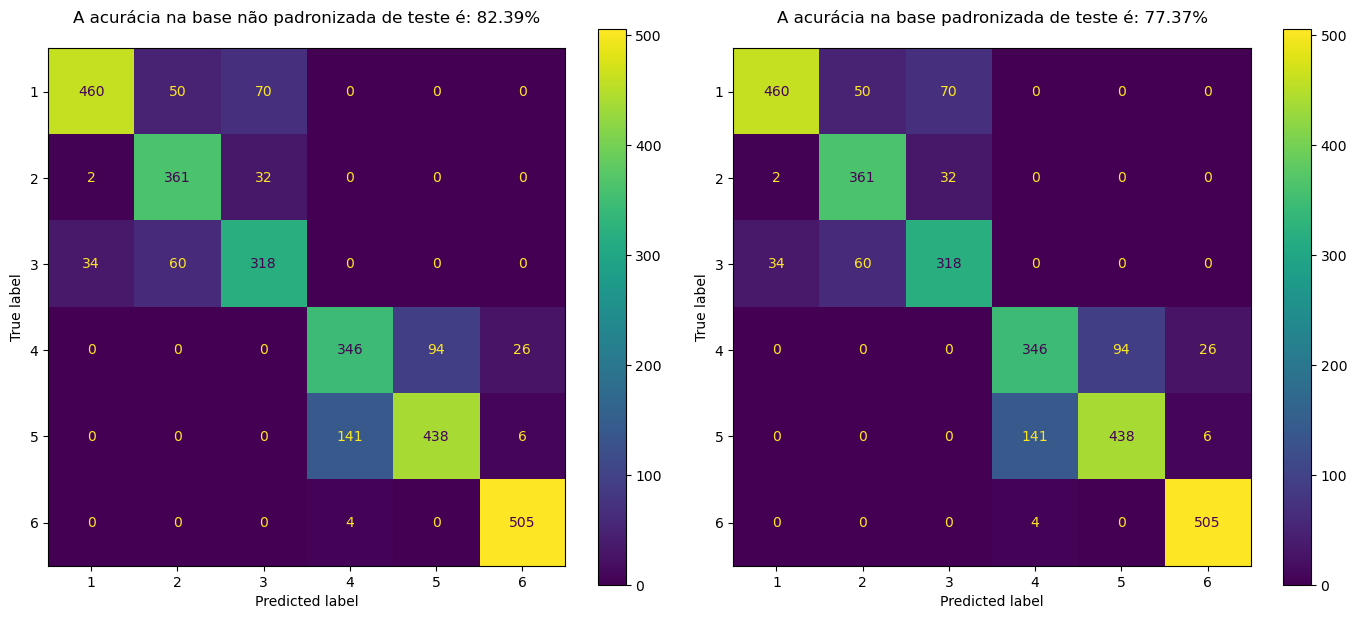

In [25]:
# Realiza a previsão dos dados
y_pred = clf.predict(pc_teste)
y_pred_pad = clf_pad.predict(pc_teste_pad)

# Cria uma figura com 1 linha e 2 colunas e define o tamanho da figura
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Configura o título do primeiro subgráfico com a acurácia na base não padronizada de teste
ax[0].set_title(f'A acurácia na base não padronizada de teste é: {accuracy_score(y_pred, y_test) * 100:.2f}%\n')

# Plota a matriz de confusão do primeiro subgráfico
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, ax=ax[0])

# Configura o título do segundo subgráfico com a acurácia na base padronizada de teste
ax[1].set_title(f'A acurácia na base padronizada de teste é: {accuracy_score(y_pred_pad, y_test) * 100:.2f}%\n')

# Plota a matriz de confusão do segundo subgráfico
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, ax=ax[1])

# Ajusta o layout dos subgráficos para evitar sobreposições
plt.tight_layout()

# Exibe o gráfico
plt.show()